In [1]:
!pip install datasets huggingface_hub scipy -q

In [81]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
import re
import warnings
warnings.filterwarnings('ignore')

ds = load_dataset('aida-ugent/JobHop')

df_train = ds['train'].to_pandas()
df_val   = ds['validation'].to_pandas()
df_test  = ds['test'].to_pandas()

df = pd.concat([df_train, df_val, df_test], ignore_index=True)

print(f'{len(df):,} rows\n')
print(f'Columns: {list(df.columns)}')
print()
print(df.head(3).to_string())

1,677,701 rows

Columns: ['person_id', 'matched_label', 'matched_description', 'matched_code', 'start_date', 'end_date', 'university_studies']

   person_id              matched_label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              matched_description matched_code start_date end_date  university_studies
0          0           resource manager                                                                   

In [82]:
print(f'Rows: {len(df):,}   Columns: {df.shape[1]}\n\n')

#columns
print(f'{df.dtypes}\n\n')

#check for missing values
print(df.isnull().sum())

print(df.head(10))

Rows: 1,677,701   Columns: 7


person_id               int64
matched_label          object
matched_description    object
matched_code           object
start_date             object
end_date               object
university_studies       bool
dtype: object


person_id                   0
matched_label               0
matched_description         0
matched_code            13876
start_date             192898
end_date               372815
university_studies          0
dtype: int64
   person_id                              matched_label  \
0          0                           resource manager   
1          0                  health and safety officer   
2          0                       integration engineer   
3          0                          programme manager   
4          0    product development engineering drafter   
5          0                               move manager   
6          0  customer contact centre information clerk   
7          0                      ICT help desk 

#Change quarter to year and remove null values

In [83]:
def quarter_to_year(q_str):

    if pd.isna(q_str):
        return np.nan
    match = re.search(r'(\d{4})', str(q_str))
    return int(match.group(1)) if match else np.nan


#clean data
before = len(df)

#remove rows with unknown in their matched_label and matched_description column
df = df[df['matched_label'].str.lower() != 'unknown'].copy()
print(f'Rows dropped: {before - len(df):,}')

df['year'] = df['start_date'].apply(quarter_to_year)

#drop rows with missing start date
before = len(df)
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)
print(f'Rows dropped {before - len(df):,} ')

df = df.sort_values(['person_id', 'year'])

print(f'\nClean dataset: {len(df):,} rows')
print(f'Users: {df["person_id"].nunique():,}')
print(f'Unique jobs: {df["matched_label"].nunique():,}')
print(f'Year range: {df["year"].min()} – {df["year"].max()}')

Rows dropped: 271,837
Rows dropped 190,289 

Clean dataset: 1,215,575 rows
Users: 314,875
Unique jobs: 2,959
Year range: 1955 – 2024


#Preprocessing and normalize titles

In [149]:
import pandas as pd
import numpy as np

def esco_title(title):

    title = str(title).lower()
    if any(x in title for x in ['software', 'developer', 'engineer', 'it ', 'data', 'systems', 'ict', 'computer']):
        return 'ICT Professionals'
    elif any(x in title for x in ['manager', 'director', 'lead', 'executive', 'chief', 'head', 'coordinator']):
        return 'Management & Business'
    elif any(x in title for x in ['sales', 'marketing', 'account', 'retail', 'brand', 'customer']):
        return 'Sales & Marketing'
    elif any(x in title for x in ['finance', 'accounting', 'bank', 'audit', 'tax', 'economist']):
        return 'Finance & Economics'
    elif any(x in title for x in ['admin', 'office', 'clerk', 'receptionist', 'secretary', 'assistant']):
        return 'Administrative Support'
    elif any(x in title for x in ['teacher', 'professor', 'research', 'scientist', 'academic', 'tutor']):
        return 'Education & Science'
    elif any(x in title for x in ['nurse', 'doctor', 'medical', 'health', 'physician', 'clinic']):
        return 'Health Professionals'
    return 'Other Specialist Services'

class PreprocessJobData:
    def __init__(self, df):
        self.df = df.copy()

    def process(self):
        # normalize and map to ESCO Sectors
        self.df['esco_sector'] = self.df['matched_label'].apply(esco_title)

        # sort by user and year
        self.df = self.df.sort_values(['person_id', 'year'])

        # extract sequences
        self.df['next_sector'] = self.df.groupby('person_id')['esco_sector'].shift(-1)

        #remove rows without a transition target
        return self.df.dropna(subset=['next_sector']).copy()

preprocessor = PreprocessJobData(df)
transitions = preprocessor.process()

#Static Markov Model

In [150]:
import numpy as np
import pandas as pd

class CareerTransitionModel:
    def __init__(self, career_data, smoothing=0.05):
        self.data = career_data
        self.epsilon = smoothing
        self.probabilities = None
        self.sector_map = None
        self.id_to_sector = None

    def transition_patterns(self):
        #create transition table
        transition_counts = pd.crosstab(self.data['esco_sector'], self.data['next_sector'])

        #check if the model recognizes every possible sector
        all_sectors = sorted(set(transition_counts.index) | set(transition_counts.columns))
        transition_counts = transition_counts.reindex(index=all_sectors, columns=all_sectors, fill_value=0)

        #calculate sparsity to see how diversity of career path
        total_paths = transition_counts.size
        unobserved_paths = np.count_nonzero(transition_counts.values == 0)
        coverage_gap = (unobserved_paths / total_paths) * 100

        print(f"Unique Sectors : {len(all_sectors)}")
        print(f"Actual Zero Paths:     {unobserved_paths}")
        print(f"Sparsity: {coverage_gap:.2f}%")

        weighted_matrix = transition_counts.values.astype(float) + self.epsilon
        self.probabilities = weighted_matrix / weighted_matrix.sum(axis=1, keepdims=True)

        self.sector_map = {name: i for i, name in enumerate(all_sectors)}
        self.id_to_sector = {i: name for name, i in self.sector_map.items()}

    def next_sector(self, current_sector, top_k=3):
        #Predicts the most probable next sectors based on historical career movements.
        if current_sector not in self.sector_map:
            return []

        sector_idx = self.sector_map[current_sector]
        likelihoods = self.probabilities[sector_idx]

        # Sort by highest probability
        best_matches = np.argsort(likelihoods)[::-1][:top_k]

        return [(self.id_to_sector[i], likelihoods[i]) for i in best_matches]

#Dynamic Markov Model

In [151]:
class DynamicMarkovModel:
    def __init__(self, transitions_df, time_col='year', current_col='esco_sector', next_col='next_sector'):
        self.transitions = transitions_df
        self.time_col = time_col
        self.current_col = current_col
        self.next_col = next_col
        self.time_windows = []
        self.transition_matrices = {}
        self.global_matrix = None
        self.job_index = None
        self.drift_scores = {}

    def create_time_intervals(self, window_size=10):
        years = sorted(self.transitions[self.time_col].unique())
        self.time_windows = []
        for i in range(0, len(years), window_size):
            start = years[i]
            end = years[min(i + window_size - 1, len(years) - 1)]
            self.time_windows.append((start, end))
        return self.time_windows

    def build_matrices(self, smoothing=0.05):
        #combine all unique ESCO sectors
        all_jobs = sorted(set(self.transitions[self.current_col].unique()) |
                          set(self.transitions[self.next_col].unique()))
        self.job_index = {job: i for i, job in enumerate(all_jobs)}

        #if a sector doesn't exist
        global_counts = pd.crosstab(self.transitions[self.current_col],
                                    self.transitions[self.next_col])
        global_counts = global_counts.reindex(index=all_jobs, columns=all_jobs, fill_value=0)

        g_mat = global_counts.values.astype(float) + smoothing
        self.global_matrix = g_mat / g_mat.sum(axis=1, keepdims=True)

        #sparsity for time intervals
        print("-" * 40)
        print(f"{'Years':<15} | {'Sparsity':<10} | {'Status'}")
        print("-" * 40)

        for start, end in self.time_windows:
            window_data = self.transitions[self.transitions[self.time_col].between(start, end)]
            if window_data.empty:
                print(f"{start}-{end:<7} | {'N/A':>8} | Empty")
                continue

            counts = pd.crosstab(window_data[self.current_col], window_data[self.next_col])
            counts = counts.reindex(index=all_jobs, columns=all_jobs, fill_value=0)

            #calculate sparsity for time interval
            w_vals = counts.values
            w_sparsity = (np.count_nonzero(w_vals == 0) / w_vals.size) * 100

            #apply smoothing
            w_mat = w_vals.astype(float) + smoothing
            self.transition_matrices[(start, end)] = w_mat / w_mat.sum(axis=1, keepdims=True)

            print(f"{start}-{end:<7} | {w_sparsity:>8.2f}% | Built")

    def compute_drift(self):
        time_intervals = sorted(self.transition_matrices.keys())
        self.drift_scores = {}
        for i in range(1, len(time_intervals)):
            prev, curr = time_intervals[i-1], time_intervals[i]
            diff = self.transition_matrices[curr] - self.transition_matrices[prev]
            self.drift_scores[curr] = norm(diff, 'fro')
        return self.drift_scores

    def prob(self, current_job, next_job, year=None):
        if current_job not in self.job_index or next_job not in self.job_index:
            return 1.0 / len(self.job_index)

        c_idx, n_idx = self.job_index[current_job], self.job_index[next_job]

        if year:
            for (s, e), mat in self.transition_matrices.items():
                if s <= year <= e:
                    return mat[c_idx, n_idx]

        return self.global_matrix[c_idx, n_idx]

    def plot_drift_over_time(self):
        year_gap = sorted(self.drift_scores.keys())
        labels = [f"{w[0]}-{w[1]}" for w in year_gap]
        scores = [self.drift_scores[w] for w in year_gap]

        plt.figure(figsize=(12, 5))
        plt.plot(labels, scores, marker='o', color='black', linewidth=1.5, label='Market Drift')
        plt.title('Market Drift', fontweight='bold')
        plt.xlabel('Year Size ')
        plt.ylabel('Drift Magnitude (Frobenius Norm)')

        plt.grid(axis='y', linestyle=':', alpha=0.6)
        sns.despine()

        plt.legend()
        plt.tight_layout()
        plt.show()

#Drift Risk Calculator

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class CareerDriftRisk:
    def __init__(self, career_model, user_col='person_id', current_col='esco_sector', next_col='next_sector', time_col='year'):
        self.model = career_model
        self.user_id = user_col
        self.sector = current_col
        self.next_sector = next_col
        self.year = time_col

    def next_path(self, transition_data, min_history=1):
        career_next = []
        for p, c_path in transition_data.groupby(self.user_id):
            if len(c_path) < min_history:
                continue

            outlier_jobs = []
            for _, step in c_path.iterrows():
                # Correctly calls .prob() from your DynamicMarkovModel
                probability = self.model.prob(
                    step[self.sector],
                    step[self.next_sector],
                    step[self.year]
                )
                outlier_jobs.append(np.log(max(probability, 1e-9)))

            drift_score = -np.mean(outlier_jobs)
            career_next.append({
                'person_id': p,
                'drift_score': drift_score,
                'total_transitions': len(c_path)
            })

        return pd.DataFrame(career_next).sort_values('drift_score', ascending=False)

    def plot_drift(self, drift_df):
        plt.figure(figsize=(10, 6))
        sns.histplot(drift_df['drift_score'], bins=50, color='gray', linewidth=0.5, alpha=0.8)
        avg_drift = drift_df['drift_score'].median()
        plt.axvline(avg_drift, color='red', linestyle='--', label=f'Market Median: {avg_drift:.2f}')
        plt.title('Career Drift Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Drift Magnitude')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        sns.despine()
        plt.show()

#Create Job Sequences

In [180]:
import time
t0 = time.time()

#map to ESCO Sectors
df['esco_sector'] = df['matched_label'].apply(esco_title)

# sort per person
df = df.sort_values(['person_id', 'year']).copy()

#extract next Sector
df['next_sector'] = df.groupby('person_id')['esco_sector'].shift(-1)

#clean transitions
transitions = df.dropna(subset=['next_sector']).copy()
print(f' Successfully extracted {len(transitions):,} sector-level transitions')

#new sparsity
unique_pairs = transitions.groupby(["esco_sector", "next_sector"]).ngroups
total_possible = len(transitions['esco_sector'].unique()) ** 2
sparsity = (1 - (unique_pairs / total_possible)) * 100

print(f' Unique Sector pairs: {unique_pairs}')
print(f' Sector Matrix Sparsity: {sparsity:.2f}%')
print('-' * 50)

# Display the sequence
print(transitions[['person_id', 'esco_sector', 'next_sector', 'year']].head(8).to_string(index=False))

 Successfully extracted 900,700 sector-level transitions
 Unique Sector pairs: 64
 Sector Matrix Sparsity: 0.00%
--------------------------------------------------
 person_id           esco_sector           next_sector  year
         0   Education & Science     ICT Professionals  1996
         0     ICT Professionals     ICT Professionals  2000
         0     ICT Professionals     Sales & Marketing  2002
         0     Sales & Marketing Management & Business  2004
         0 Management & Business     ICT Professionals  2006
         0     ICT Professionals Management & Business  2011
         0 Management & Business     ICT Professionals  2012
         0     ICT Professionals Management & Business  2013


#Split Dataset

In [181]:
import numpy as np

np.random.seed(42)

# 1. Get unique users
unique_users = transitions['person_id'].unique()
np.random.shuffle(unique_users)

# 2. Calculate split index
TEST_SIZE = 0.2
split_idx = int(len(unique_users) * (1 - TEST_SIZE))

# 3. Divide users
train_users = unique_users[:split_idx]
test_users  = unique_users[split_idx:]

train_data = transitions[transitions['person_id'].isin(train_users)].copy()
test_data  = transitions[transitions['person_id'].isin(test_users)].copy()

print(f'Total Users: {len(unique_users):,}')
print(f'Train: {len(train_data):,} transitions ({len(train_users):,} users)')
print(f'Test : {len(test_data):,} transitions ({len(test_users):,}, users)')

Total Users: 263,854
Train: 721,221 transitions (211,083 users)
Test : 179,479 transitions (52,771, users)


#Build Career Sequences

In [182]:
#build matrixes
static = CareerTransitionModel(
    career_data = train_data,
    smoothing      = 0.05
)

static.transition_patterns()

Unique Sectors : 8
Actual Zero Paths:     0
Sparsity: 0.00%


----------------------------------------
Years           | Sparsity   | Status
----------------------------------------
1958-1969    |    73.44% | Built
1970-1979    |     7.81% | Built
1980-1989    |     0.00% | Built
1990-1999    |     0.00% | Built
2000-2009    |     0.00% | Built
2010-2019    |     0.00% | Built
2020-2024    |    15.62% | Built


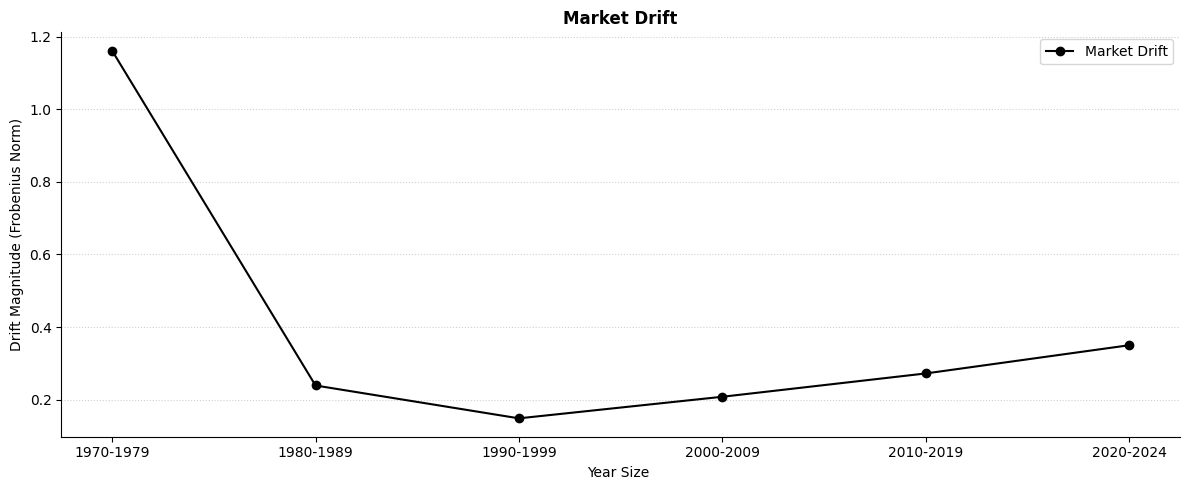

In [183]:
dynamic = DynamicMarkovModel(
    transitions_df = train_data,
    time_col       = 'year',
    current_col    = 'esco_sector',
    next_col       = 'next_sector'
)

#create time interval
dynamic.create_time_intervals(window_size=10)

#build Matrices
dynamic.build_matrices(smoothing=0.05)

#compute and plot drift
dynamic.compute_drift()
dynamic.plot_drift_over_time()

#Evaluate Model

In [184]:
import numpy as np
import pandas as pd

class MarkovPredictor:
    def __init__(self, static_model, dynamic_model):
        self.static = static_model
        self.dynamic = dynamic_model

    # Persistence Baseline
    def evaluate_persistence(self, test_df, current_col='esco_sector', next_col='next_sector'):
        #Measures the accuracy if we simply predict the next job will be in the same sector.
        correct = (test_df[current_col] == test_df[next_col]).sum()
        accuracy = correct / len(test_df) if len(test_df) > 0 else 0

        print(f"Persistence Baseline")
        print(f"Top-1 Accuracy: {accuracy:.2%}")
        return accuracy

    # Static Model Evaluation
    def evaluate_static(self, test_df, current_col='esco_sector', next_col='next_sector', top_k_list=[1, 3, 5]):
        correct = {k: 0 for k in top_k_list}
        total = 0

        for _, row in test_df.iterrows():
            curr, actual = row[current_col], row[next_col]
            if curr not in self.static.sector_map:
                continue

            total += 1
            preds = self.static.next_sector(curr, top_k=max(top_k_list))
            pred_jobs = [p[0] for p in preds]

            for k in top_k_list:
                if actual in pred_jobs[:k]:
                    correct[k] += 1

        accuracies = {f'top_{k}': correct[k]/total if total > 0 else 0 for k in top_k_list}
        print(f"\nStatic Model Results")
        for k, acc in accuracies.items():
            print(f"Static {k.upper()}: {acc:.2%}")
        return accuracies

    # Dynamic Model Evaluation
    def evaluate_dynamic(self, test_df, current_col='esco_sector', next_col='next_sector', time_col='year', top_k_list=[1, 3, 5]):

        correct = {k: 0 for k in top_k_list}
        total = 0
        all_jobs = list(self.dynamic.job_index.keys())

        for _, row in test_df.iterrows():
            curr, actual, yr = row[current_col], row[next_col], row[time_col]
            if curr not in self.dynamic.job_index:
                continue

            total += 1
            c_idx = self.dynamic.job_index[curr]

            probs = self.dynamic.global_matrix[c_idx]
            for (s, e), mat in self.dynamic.transition_matrices.items():
                if s <= yr <= e:
                    probs = mat[c_idx]
                    break

            top_indices = np.argsort(probs)[::-1][:max(top_k_list)]
            pred_jobs = [all_jobs[i] for i in top_indices]

            for k in top_k_list:
                if actual in pred_jobs[:k]:
                    correct[k] += 1

        accuracies = {f'top_{k}': correct[k]/total if total > 0 else 0 for k in top_k_list}
        print(f"\nDynamic Model Results")
        for k, acc in accuracies.items():
            print(f"Dynamic {k.upper()}: {acc:.2%}")
        return accuracies

#Calculate Accuracy

In [185]:
predictor = MarkovPredictor(static, dynamic)

#Persistence Baseline
persistence_acc = predictor.evaluate_persistence(
    test_data,
    current_col = 'esco_sector',
    next_col    = 'next_sector'
)

#Static Model Accuracy
static_results = predictor.evaluate_static(
    test_data,
    current_col = 'esco_sector',
    next_col    = 'next_sector',
    top_k_list  = [1, 3, 5]
)

#Dynamic Model Accuracy
dynamic_results = predictor.evaluate_dynamic(
    test_data,
    current_col = 'esco_sector',
    next_col    = 'next_sector',
    time_col    = 'year',
    top_k_list  = [1, 3, 5]
)


print(f"Persistence Baseline (Top-1):    {persistence_acc:.2%}")
print(f"Static Model (Top-1):            {static_results['top_1']:.2%}")
print(f"Dynamic Model (Top-1):           {dynamic_results['top_1']:.2%}")

print(f"Static vs Baseline:  {static_results['top_1'] - persistence_acc:+.2%}")
print(f"Dynamic vs Baseline: {dynamic_results['top_1'] - persistence_acc:+.2%}")


Persistence Baseline
Top-1 Accuracy: 52.06%

Static Model Results
Static TOP_1: 52.64%
Static TOP_3: 85.50%
Static TOP_5: 96.56%

Dynamic Model Results
Dynamic TOP_1: 52.85%
Dynamic TOP_3: 85.80%
Dynamic TOP_5: 96.64%
Persistence Baseline (Top-1):    52.06%
Static Model (Top-1):            52.64%
Dynamic Model (Top-1):           52.85%
Static vs Baseline:  +0.59%
Dynamic vs Baseline: +0.79%


#Visualize Drift Risk

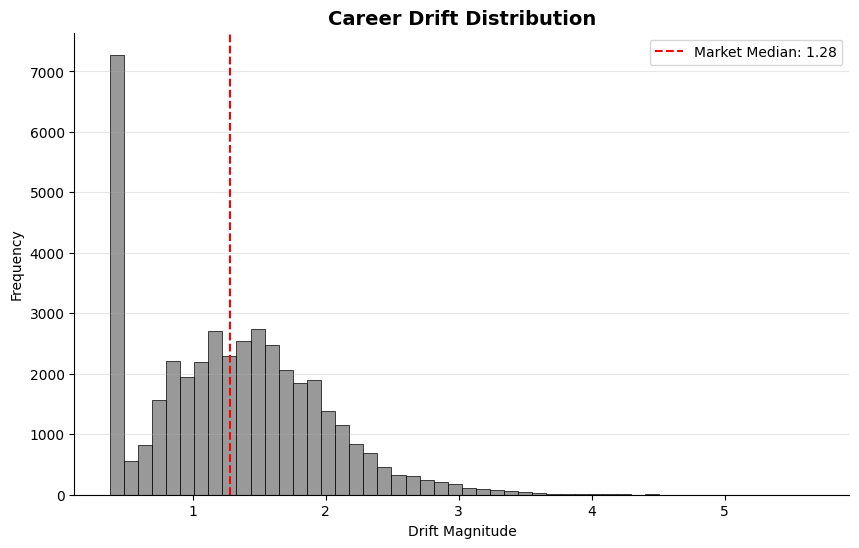

In [186]:
scorer = CareerDriftRisk(
    career_model = dynamic,
    user_col      = 'person_id',
    current_col   = 'esco_sector',
    next_col      = 'next_sector',
    time_col      = 'year'
)

risk_df = scorer.next_path(test_data, min_history=2)

scorer.plot_drift(risk_df)

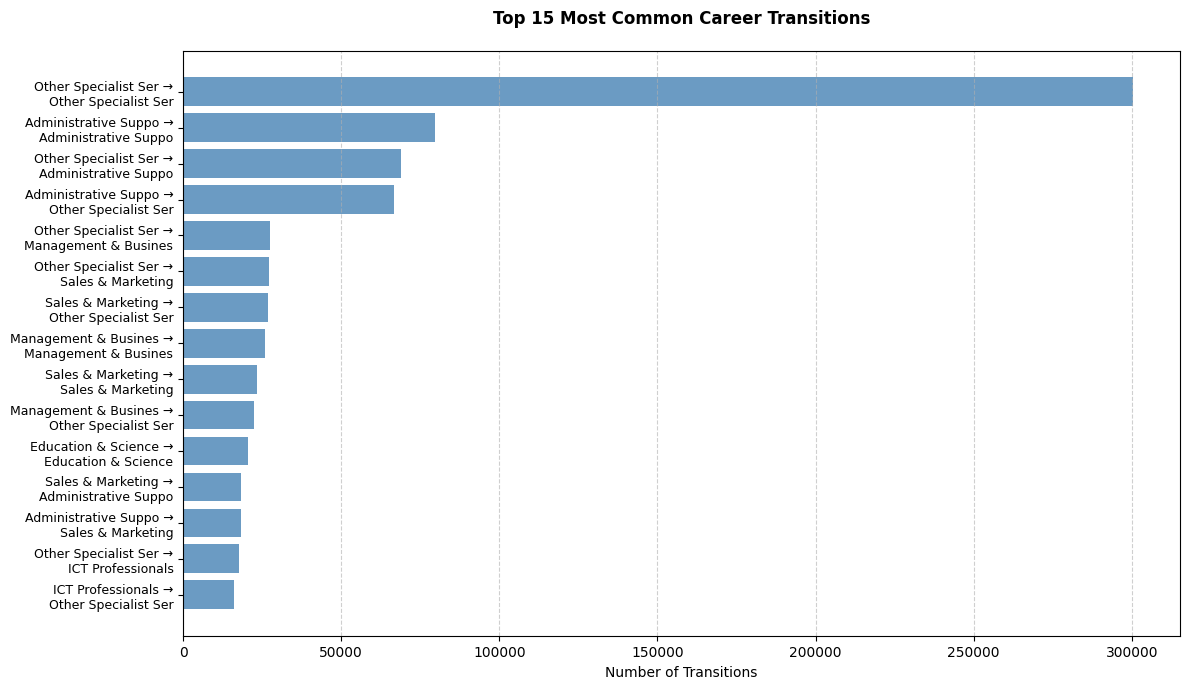

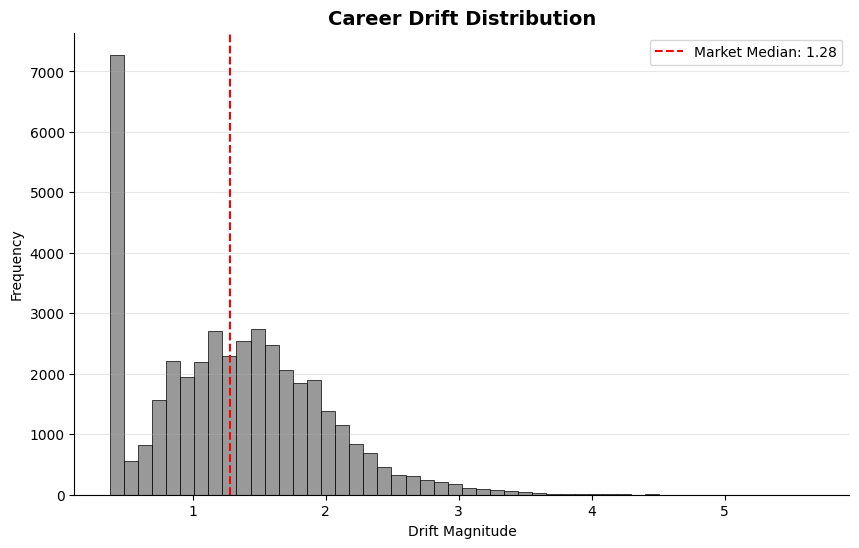


TOP 10 HIGHEST DRIFT RISK USERS (OUTLIERS)
 person_id  drift_score  total_transitions
    350003     5.672761                  2
    324804     4.732176                  2
    220522     4.613606                  2
    175996     4.574935                  2
     51070     4.521941                  2
    219385     4.500333                  2
    372498     4.420644                  2
     13198     4.420644                  2
    257033     4.420644                  2
    267702     4.392059                  2


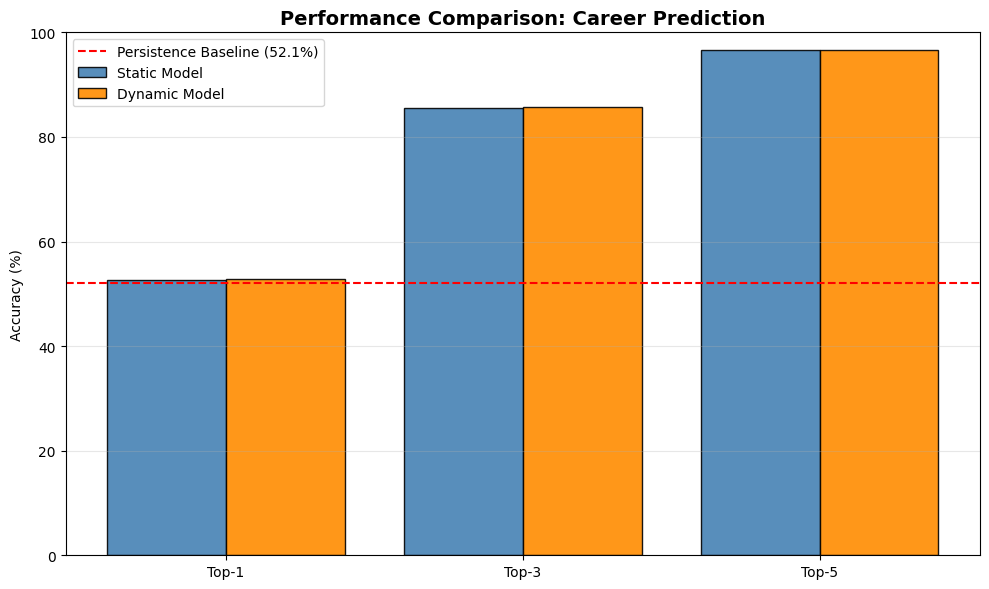

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Top 15 Transitions Plot
top_transitions = (
    transitions
    .groupby(['esco_sector', 'next_sector'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
    .head(15)
)

top_transitions['pair'] = (
    top_transitions['esco_sector'].astype(str).str[:20] +
    ' →\n' +
    top_transitions['next_sector'].astype(str).str[:20]
)

plt.figure(figsize=(12, 7))
plt.barh(range(15), top_transitions['count'], color='steelblue', alpha=0.8)
plt.yticks(range(15), top_transitions['pair'], fontsize=9)
plt.gca().invert_yaxis()
plt.xlabel('Number of Transitions')
plt.title('Top 15 Most Common Career Transitions', fontweight='bold', pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# High-Risk Users Calculation and Plot
scorer = CareerDriftRisk(
    career_model = dynamic,
    user_col      = 'person_id',
    current_col   = 'esco_sector',
    next_col      = 'next_sector',
    time_col      = 'year'
)

risk_df = scorer.next_path(test_data, min_history=2)
scorer.plot_drift(risk_df)

print('\nTOP 10 HIGHEST DRIFT RISK USERS (OUTLIERS)')
print(risk_df.nlargest(10, 'drift_score').to_string(index=False))

#Accuracy Comparison Plot
metrics_keys = ['top_1', 'top_3', 'top_5']
labels = ['Top-1', 'Top-3', 'Top-5']

# Ensuring accuracy variables are pulled correctly from your evaluation cell
s_vals = [static_results.get(m, 0)*100 for m in metrics_keys]
d_vals = [dynamic_results.get(m, 0)*100 for m in metrics_keys]
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, s_vals, width=0.4, label='Static Model', color='steelblue', edgecolor='black', alpha=0.9)
plt.bar(x + 0.2, d_vals, width=0.4, label='Dynamic Model', color='darkorange', edgecolor='black', alpha=0.9)

if 'persistence_acc' in locals():
    plt.axhline(y=persistence_acc*100, color='red', linestyle='--', linewidth=1.5, label=f'Persistence Baseline ({persistence_acc*100:.1f}%)')

plt.xticks(x, labels)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Performance Comparison: Career Prediction', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

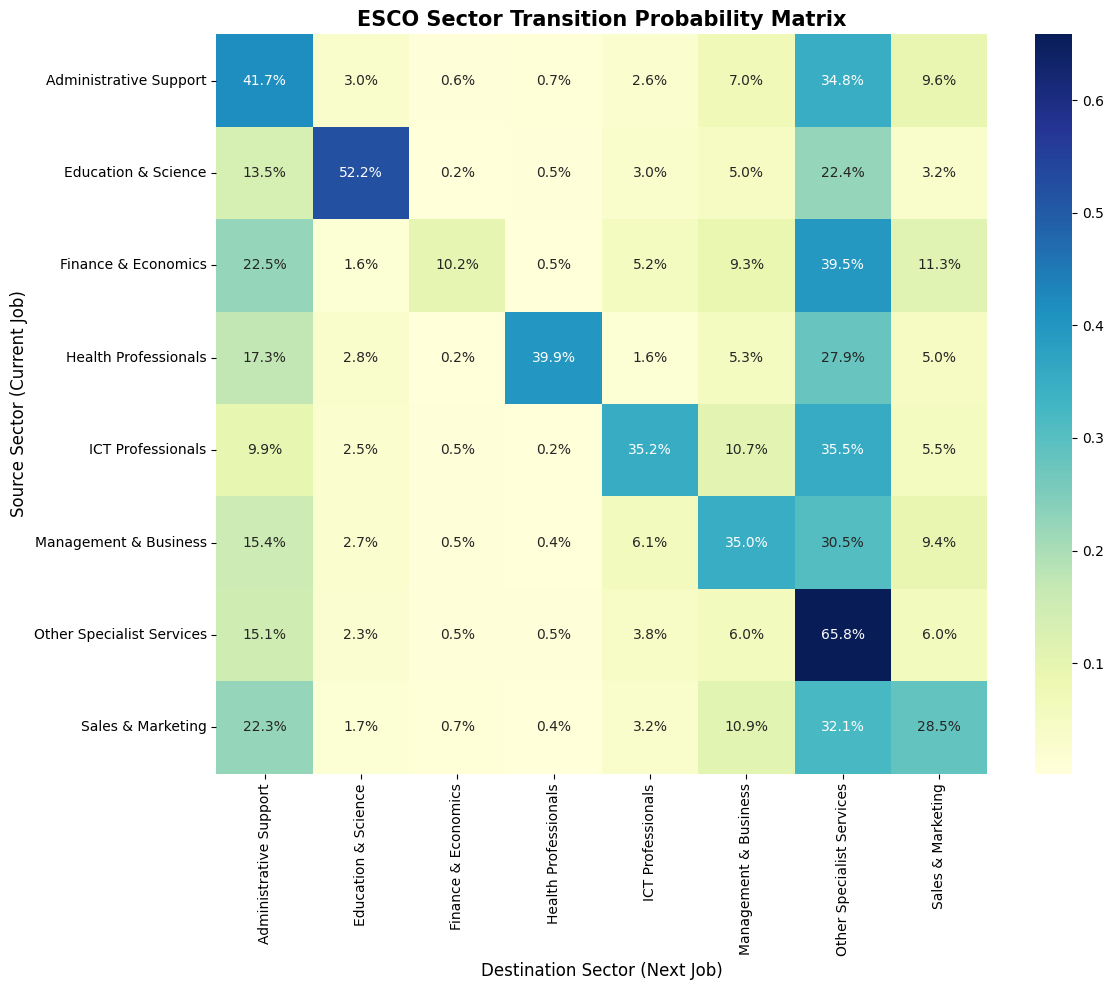

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(static.probabilities,
            annot=True,
            fmt=".1%",
            cmap="YlGnBu",
            xticklabels=static.sector_map.keys(),
            yticklabels=static.sector_map.keys())

plt.title("ESCO Sector Transition Probability Matrix", fontsize=15, fontweight='bold')
plt.xlabel("Destination Sector (Next Job)", fontsize=12)
plt.ylabel("Source Sector (Current Job)", fontsize=12)
plt.tight_layout()
plt.show()